# Import Packages and Load Datasets:

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier

from sklearn.linear_model import LogisticRegression

In [2]:
train_raw = pd.read_csv('train.csv')
test_raw = pd.read_csv('test.csv')
train = train_raw.copy()
test = test_raw.copy()

In [3]:
train.head(3)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y


In [4]:
test.head(3)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban


In [5]:
train.drop_duplicates(keep='first', inplace=True)

In [6]:
train.drop('Loan_ID', axis=1, inplace=True)
test.drop('Loan_ID', axis=1, inplace=True)

# EDA

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             601 non-null    object 
 1   Married            611 non-null    object 
 2   Dependents         599 non-null    object 
 3   Education          614 non-null    object 
 4   Self_Employed      582 non-null    object 
 5   ApplicantIncome    614 non-null    int64  
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         592 non-null    float64
 8   Loan_Amount_Term   600 non-null    float64
 9   Credit_History     564 non-null    float64
 10  Property_Area      614 non-null    object 
 11  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(7)
memory usage: 62.4+ KB


In [8]:
for col in train.columns:
    print('Number of unique values in ' + col + ' are: ' +str(train[col].nunique()))

Number of unique values in Gender are: 2
Number of unique values in Married are: 2
Number of unique values in Dependents are: 4
Number of unique values in Education are: 2
Number of unique values in Self_Employed are: 2
Number of unique values in ApplicantIncome are: 505
Number of unique values in CoapplicantIncome are: 287
Number of unique values in LoanAmount are: 203
Number of unique values in Loan_Amount_Term are: 10
Number of unique values in Credit_History are: 2
Number of unique values in Property_Area are: 3
Number of unique values in Loan_Status are: 2


In [9]:
for item in [train, test]:
    print(item.isnull().sum())
    print('=================')

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64
Gender               11
Married               0
Dependents           10
Education             0
Self_Employed        23
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            5
Loan_Amount_Term      6
Credit_History       29
Property_Area         0
dtype: int64


<AxesSubplot:>

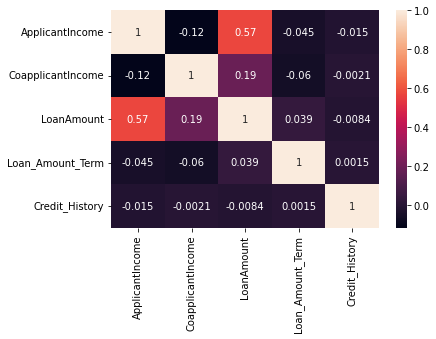

In [10]:
sns.heatmap(train.corr(), annot=True)

# Fill Missing Values

In [11]:
# Categorical Features
train['Gender'] = train['Gender'].ffill().bfill()
test['Gender'] = test['Gender'].ffill().bfill()
train['Married'].fillna('No', inplace=True)
train['Dependents'].fillna('0', inplace=True)
test['Dependents'].fillna('0', inplace=True)
train['Self_Employed'].fillna('No', inplace=True)
test['Self_Employed'].fillna('No', inplace=True)
train['Credit_History'].replace({1.:'Yes', 0.:'No'}, inplace=True)
test['Credit_History'].replace({1.:'Yes', 0.:'No'}, inplace=True)
train['Credit_History'].fillna('No', inplace=True)
test['Credit_History'].fillna('No', inplace=True)

In [12]:
train['LoanAmount'].fillna(train['LoanAmount'].median(), inplace=True)
test['LoanAmount'].fillna(test['LoanAmount'].median(), inplace=True)
train['Loan_Amount_Term'].fillna(train['Loan_Amount_Term'].median(), inplace=True)
test['Loan_Amount_Term'].fillna(test['Loan_Amount_Term'].median(), inplace=True)

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             614 non-null    object 
 1   Married            614 non-null    object 
 2   Dependents         614 non-null    object 
 3   Education          614 non-null    object 
 4   Self_Employed      614 non-null    object 
 5   ApplicantIncome    614 non-null    int64  
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         614 non-null    float64
 8   Loan_Amount_Term   614 non-null    float64
 9   Credit_History     614 non-null    object 
 10  Property_Area      614 non-null    object 
 11  Loan_Status        614 non-null    object 
dtypes: float64(3), int64(1), object(8)
memory usage: 62.4+ KB


# Split Data into Features and Target

In [14]:
X_train = train.drop('Loan_Status', axis=1)

In [15]:
y_train = train['Loan_Status'].replace({'Y': 1, 'N': 0})

In [16]:
X_test = test.copy()

In [17]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 614 entries, 0 to 613
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             614 non-null    object 
 1   Married            614 non-null    object 
 2   Dependents         614 non-null    object 
 3   Education          614 non-null    object 
 4   Self_Employed      614 non-null    object 
 5   ApplicantIncome    614 non-null    int64  
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         614 non-null    float64
 8   Loan_Amount_Term   614 non-null    float64
 9   Credit_History     614 non-null    object 
 10  Property_Area      614 non-null    object 
dtypes: float64(3), int64(1), object(7)
memory usage: 57.6+ KB


In [18]:
X_train_cat = X_train.select_dtypes(include='object')
X_train_num = X_train.select_dtypes(include=['int64','float64'])
X_test_cat = X_test.select_dtypes(include='object')
X_test_num = X_test.select_dtypes(include=['int64','float64'])

In [19]:
X_test_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Gender          367 non-null    object
 1   Married         367 non-null    object
 2   Dependents      367 non-null    object
 3   Education       367 non-null    object
 4   Self_Employed   367 non-null    object
 5   Credit_History  367 non-null    object
 6   Property_Area   367 non-null    object
dtypes: object(7)
memory usage: 20.2+ KB


# Data Encoding: pd.get_dummies

In [20]:
def df_encode(encode_data):
    encode_data = pd.get_dummies(encode_data)
    return encode_data

In [21]:
X_train_cat_encoded = df_encode(X_train_cat)
X_test_cat_encoded = df_encode(X_test_cat)

In [22]:
X_train_cat_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 614 entries, 0 to 613
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   Gender_Female            614 non-null    uint8
 1   Gender_Male              614 non-null    uint8
 2   Married_No               614 non-null    uint8
 3   Married_Yes              614 non-null    uint8
 4   Dependents_0             614 non-null    uint8
 5   Dependents_1             614 non-null    uint8
 6   Dependents_2             614 non-null    uint8
 7   Dependents_3+            614 non-null    uint8
 8   Education_Graduate       614 non-null    uint8
 9   Education_Not Graduate   614 non-null    uint8
 10  Self_Employed_No         614 non-null    uint8
 11  Self_Employed_Yes        614 non-null    uint8
 12  Credit_History_No        614 non-null    uint8
 13  Credit_History_Yes       614 non-null    uint8
 14  Property_Area_Rural      614 non-null    uint8
 15  Proper

# Data Scaling with RobustScaler, MinMaxScaler, and StandardScaler

In [23]:
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train_num)
X_test_scaled = ss.transform(X_test_num)

In [24]:
X_train_scaled = pd.DataFrame(X_train_scaled)
X_test_scaled = pd.DataFrame(X_test_scaled)

In [25]:
X_train = pd.concat([X_train_cat_encoded, X_train_scaled], axis=1)
X_test = pd.concat([X_test_cat_encoded, X_test_scaled], axis=1)

In [26]:
X_train.rename(columns={0:'ApplicantIncome', 1:'CoapplicantIncome', 2:'LoanAmount', 3:'Loan_Amount_Term'}, inplace=True)
X_test.rename(columns={0:'ApplicantIncome', 1:'CoapplicantIncome', 2:'LoanAmount', 3:'Loan_Amount_Term'}, inplace=True)

In [27]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)

In [28]:
y_train.value_counts()

1    422
0    192
Name: Loan_Status, dtype: int64

In [29]:
# Value for scale_pos_weight
192/422

0.4549763033175355

# Baseline Model and Hyperparameter Tuning

In [30]:
xgbc = XGBClassifier(scale_pos_weight=.45, objective='binary:hinge', use_label_encoder=False)
lgbmc = LGBMClassifier(scale_pos_weight=.45, objective='binary')
catc = CatBoostClassifier(scale_pos_weight=.45)
lrc = LogisticRegression(solver='liblinear', class_weight='balanced')
rfc = RandomForestClassifier(class_weight='balanced')

In [31]:
scores = cross_val_score(xgbc, X_train, y_train, cv=kfold)
print('Accuracy scores:', np.round(scores,2))
print('Accuracy mean:', np.round(scores.mean(),2))

[20:50:25] WARNING: ..\src\learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:50:25] WARNING: ..\src\learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:50:25] WARNING: ..\src\learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actual

In [36]:
def random_grid_search(model, params):
    r_grid = RandomizedSearchCV(model, params, n_iter=20, cv=kfold, n_jobs=-1)
    r_grid.fit(X_train_scaled, y_train)
    best_params = r_grid.best_params_
    print('Best params', best_params)
    best_score = r_grid.best_score_
    print('Best score:', best_score)

In [37]:
def grid_search(model, params):
    grid = GridSearchCV(model, params, cv=kfold, n_jobs=-1)
    grid.fit(X_train_scaled, y_train)
    best_params = grid.best_params_
    print('Best params', best_params)
    best_score = grid.best_score_
    print('Best score:', best_score) 

In [38]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_train, y_train, random_state=7)

In [39]:
def check(model):
    model.fit(Xtrain, ytrain)
    ypred = model.predict(Xtest)
    print('Accuracy score:', accuracy_score(ypred, ytest))

In [40]:
check(xgbc)

[20:50:36] WARNING: ..\src\learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Accuracy score: 0.7597402597402597


In [41]:
check(lgbmc)

Accuracy score: 0.7467532467532467


In [42]:
check(catc)

Learning rate set to 0.007395
0:	learn: 0.6910488	total: 2.13ms	remaining: 2.13s
1:	learn: 0.6894689	total: 3.72ms	remaining: 1.86s
2:	learn: 0.6876335	total: 5.92ms	remaining: 1.97s
3:	learn: 0.6858912	total: 7.75ms	remaining: 1.93s
4:	learn: 0.6835246	total: 9.49ms	remaining: 1.89s
5:	learn: 0.6811573	total: 11.2ms	remaining: 1.86s
6:	learn: 0.6790637	total: 12.9ms	remaining: 1.83s
7:	learn: 0.6769482	total: 14.6ms	remaining: 1.8s
8:	learn: 0.6751847	total: 16.7ms	remaining: 1.84s
9:	learn: 0.6739699	total: 17.7ms	remaining: 1.75s
10:	learn: 0.6721469	total: 19.4ms	remaining: 1.74s
11:	learn: 0.6701681	total: 21.1ms	remaining: 1.74s
12:	learn: 0.6681787	total: 23ms	remaining: 1.74s
13:	learn: 0.6662912	total: 24.7ms	remaining: 1.74s
14:	learn: 0.6645036	total: 26.5ms	remaining: 1.74s
15:	learn: 0.6627040	total: 28.3ms	remaining: 1.74s
16:	learn: 0.6612193	total: 30.1ms	remaining: 1.74s
17:	learn: 0.6596301	total: 32.2ms	remaining: 1.75s
18:	learn: 0.6583709	total: 33.3ms	remaining: 1

196:	learn: 0.4961965	total: 323ms	remaining: 1.31s
197:	learn: 0.4955416	total: 325ms	remaining: 1.31s
198:	learn: 0.4949061	total: 326ms	remaining: 1.31s
199:	learn: 0.4945596	total: 328ms	remaining: 1.31s
200:	learn: 0.4942279	total: 330ms	remaining: 1.31s
201:	learn: 0.4940251	total: 332ms	remaining: 1.31s
202:	learn: 0.4933378	total: 333ms	remaining: 1.31s
203:	learn: 0.4929824	total: 335ms	remaining: 1.31s
204:	learn: 0.4929221	total: 336ms	remaining: 1.3s
205:	learn: 0.4922448	total: 338ms	remaining: 1.3s
206:	learn: 0.4916961	total: 340ms	remaining: 1.3s
207:	learn: 0.4911223	total: 342ms	remaining: 1.3s
208:	learn: 0.4904345	total: 344ms	remaining: 1.3s
209:	learn: 0.4899701	total: 345ms	remaining: 1.3s
210:	learn: 0.4894869	total: 347ms	remaining: 1.3s
211:	learn: 0.4891773	total: 349ms	remaining: 1.3s
212:	learn: 0.4887385	total: 351ms	remaining: 1.29s
213:	learn: 0.4882017	total: 353ms	remaining: 1.29s
214:	learn: 0.4877857	total: 355ms	remaining: 1.29s
215:	learn: 0.487111

405:	learn: 0.4140009	total: 671ms	remaining: 982ms
406:	learn: 0.4135726	total: 673ms	remaining: 981ms
407:	learn: 0.4132730	total: 675ms	remaining: 979ms
408:	learn: 0.4128370	total: 676ms	remaining: 977ms
409:	learn: 0.4126207	total: 678ms	remaining: 976ms
410:	learn: 0.4123017	total: 680ms	remaining: 974ms
411:	learn: 0.4121336	total: 681ms	remaining: 972ms
412:	learn: 0.4117937	total: 683ms	remaining: 971ms
413:	learn: 0.4116306	total: 685ms	remaining: 969ms
414:	learn: 0.4114028	total: 687ms	remaining: 968ms
415:	learn: 0.4110956	total: 689ms	remaining: 967ms
416:	learn: 0.4106689	total: 691ms	remaining: 966ms
417:	learn: 0.4103171	total: 692ms	remaining: 964ms
418:	learn: 0.4099483	total: 694ms	remaining: 962ms
419:	learn: 0.4097453	total: 696ms	remaining: 961ms
420:	learn: 0.4095407	total: 698ms	remaining: 960ms
421:	learn: 0.4092935	total: 699ms	remaining: 958ms
422:	learn: 0.4090847	total: 701ms	remaining: 956ms
423:	learn: 0.4087556	total: 703ms	remaining: 954ms
424:	learn: 

618:	learn: 0.3574259	total: 1.02s	remaining: 629ms
619:	learn: 0.3572039	total: 1.02s	remaining: 628ms
620:	learn: 0.3571210	total: 1.02s	remaining: 626ms
621:	learn: 0.3570165	total: 1.03s	remaining: 624ms
622:	learn: 0.3567650	total: 1.03s	remaining: 622ms
623:	learn: 0.3565672	total: 1.03s	remaining: 621ms
624:	learn: 0.3562756	total: 1.03s	remaining: 619ms
625:	learn: 0.3561210	total: 1.03s	remaining: 617ms
626:	learn: 0.3557773	total: 1.03s	remaining: 616ms
627:	learn: 0.3555532	total: 1.04s	remaining: 614ms
628:	learn: 0.3552395	total: 1.04s	remaining: 613ms
629:	learn: 0.3548909	total: 1.04s	remaining: 611ms
630:	learn: 0.3547395	total: 1.04s	remaining: 609ms
631:	learn: 0.3543191	total: 1.04s	remaining: 608ms
632:	learn: 0.3541198	total: 1.04s	remaining: 606ms
633:	learn: 0.3538409	total: 1.05s	remaining: 604ms
634:	learn: 0.3535053	total: 1.05s	remaining: 603ms
635:	learn: 0.3534883	total: 1.05s	remaining: 601ms
636:	learn: 0.3532609	total: 1.05s	remaining: 599ms
637:	learn: 

825:	learn: 0.3118063	total: 1.37s	remaining: 289ms
826:	learn: 0.3114773	total: 1.37s	remaining: 287ms
827:	learn: 0.3113552	total: 1.37s	remaining: 285ms
828:	learn: 0.3112770	total: 1.38s	remaining: 284ms
829:	learn: 0.3111492	total: 1.38s	remaining: 282ms
830:	learn: 0.3110045	total: 1.38s	remaining: 280ms
831:	learn: 0.3107736	total: 1.38s	remaining: 279ms
832:	learn: 0.3105283	total: 1.38s	remaining: 277ms
833:	learn: 0.3103519	total: 1.38s	remaining: 276ms
834:	learn: 0.3101244	total: 1.39s	remaining: 274ms
835:	learn: 0.3098527	total: 1.39s	remaining: 272ms
836:	learn: 0.3096690	total: 1.39s	remaining: 271ms
837:	learn: 0.3095813	total: 1.39s	remaining: 269ms
838:	learn: 0.3093474	total: 1.39s	remaining: 267ms
839:	learn: 0.3090645	total: 1.39s	remaining: 266ms
840:	learn: 0.3088763	total: 1.4s	remaining: 264ms
841:	learn: 0.3087612	total: 1.4s	remaining: 262ms
842:	learn: 0.3084586	total: 1.4s	remaining: 261ms
843:	learn: 0.3083574	total: 1.4s	remaining: 259ms
844:	learn: 0.30

In [43]:
check(lrc)

Accuracy score: 0.7207792207792207


In [44]:
check(rfc)

Accuracy score: 0.7727272727272727


In [45]:
Classifiers = {'0.XGBoost' : XGBClassifier(eta=.001, n_estimators=400, scale_pos_weight=1.2, max_depth=1,
                                            min_child_weight=0, subsample=.65, base_score=.35),
               
               '1.CatBoost' : CatBoostClassifier(learning_rate=.01, n_estimators=35, subsample=.15,
                                                 max_depth=2, scale_pos_weight=1.2),
               
               '2.LightGBM' : LGBMClassifier(objective='binary', boosting_type='dart', learning_rate=.035,
                                             n_estimators=75, max_depth=1, scale_pos_weight=1.2),
               
               '3.LogisticRegression' : LogisticRegression(solver='liblinear', class_weight='balanced'),
               
               '4.RandomForest' : RandomForestClassifier(class_weight='balanced')
 }

print( list(Classifiers.keys()) )
print( list(Classifiers.values()) )

['0.XGBoost', '1.CatBoost', '2.LightGBM', '3.LogisticRegression', '4.RandomForest']
[XGBClassifier(base_score=0.35, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, eta=0.001, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=1,
              min_child_weight=0, missing=nan, monotone_constraints=None,
              n_estimators=400, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=1.2, subsample=0.65,
              tree_method=None, validate_parameters=None, verbosity=None), <catboost.core.CatBoostClassifier object at 0x0000021107CD3100>, LGBMClassifier(boosting_type='dart', learning_rate=0.035, max_depth=1,
               n_estimators=75, objective='binary', scale_pos_weight=1.2), LogisticRegre

# Build Ensemble using Voting Classifier

In [51]:
ensemble_model = VotingClassifier(estimators=[('XGBoost_Best', list(Classifiers.values())[0]), 
                                              ('CatBoost_Best', list(Classifiers.values())[1]),
                                              ('LightGBM_Best', list(Classifiers.values())[2]),
                                              ('LogisticRegression_Best', list(Classifiers.values())[2]),
                                              ('RandomForest_Best', list(Classifiers.values())[2]),
                                             ], 
                                              voting='hard', n_jobs=-1)

ensemble_model.fit(X_train, y_train) 

pred = ensemble_model.predict(X_test)

In [52]:
pred.shape

(367,)

In [48]:
submission = pd.DataFrame({'Loan_ID': test_raw['Loan_ID'], 'Loan_Status': pred})

In [49]:
submission['Loan_Status'].replace({1:'Y', 0:'N'}, inplace=True)

In [50]:
submission.to_csv('votesubmission3.csv', index=False)